# Tutorial 3: Finding Temporal Relationships

Welcome to the third tutorial! Now that we know how to handle temporal data, we can start asking scientific questions. The most common questions in neuroscience about two signals, X and Y, are:

1.  **What is the duration of their interaction?** Do we need to look at 10ms, 100ms, or 1s of data to capture the relationship?
2.  **Is there a time delay?** Does a change in X predict a change in Y 50ms later?

`NeuralMI` provides two powerful tools to answer these questions: sweeping on **`window_size`** to find the interaction duration, and using **`mode='lag'`** to find the precise temporal offset.

In [1]:
import numpy as np
import neural_mi as nmi
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")

## 1. The Data: A Relationship with a Known Lag

Let's create a dataset where we know the ground truth. We'll generate a signal `X` and a signal `Y` that is simply a copy of `X` lagged by **30 timepoints**. Our goal is to use the library's tools to recover both the necessary window size and this 30-step lag.

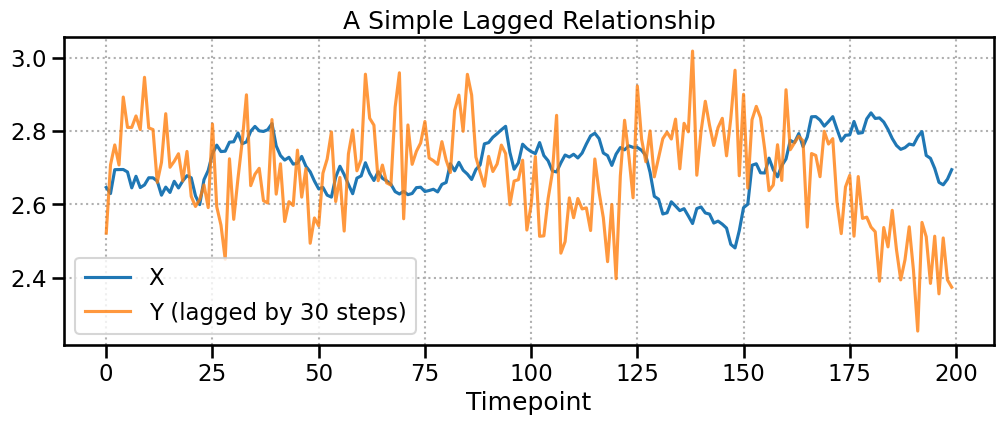

In [2]:
ground_truth_lag = 30
x_raw, y_raw = nmi.datasets.generate_temporally_convolved_data(
    n_samples=10000, lag=ground_truth_lag, noise=0.1
)

plt.figure(figsize=(12, 4))
plt.plot(x_raw[0, :200], label='X')
plt.plot(y_raw[0, :200], label=f'Y (lagged by {ground_truth_lag} steps)', alpha=0.8)
plt.title("A Simple Lagged Relationship")
plt.xlabel("Timepoint")
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

## 2. Part 1: Finding the Interaction Duration (`window_size`)

To find the right timescale, we can perform a sweep over the `window_size` parameter. We expect the MI to be low for small windows that can't see the full relationship, and to peak when the window is large enough to capture the 30-step lag.

**Important Note:** This temporal task is surprisingly complex for a model to learn. The default `SeparableCritic` can sometimes struggle to produce a clear result. To ensure our demonstration is robust, we might need to use a more powerful **`BilinearCritic`** or even a **`ConcatCritic`** combined with a `CNN` embedding model. We'll explore exactly *why* this choice matters in the next tutorial.

In [10]:
base_params = {
    'n_epochs': 50, 'learning_rate': 1e-3, 'batch_size': 64,
    'patience': 20, 'embedding_dim': 16, 'hidden_dim': 128, 'n_layers': 2,
    'embedding_model': 'cnn',       # Use a CNN for temporal data
    # 'critic_type': 'bilinear'     # Use a powerful critic for a clear result
}

sweep_grid = {'window_size': [1, 10, 20, 30, 40, 60, 100],
             'run_id': range(3)}

window_results = nmi.run(
    x_data=x_raw, y_data=y_raw, mode='sweep',
    processor_type_x='continuous', processor_params_x={},
    base_params=base_params,
    sweep_grid=sweep_grid, 
    n_workers=2, 
    random_seed=42
)

2025-10-08 02:30:46 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-08 02:30:46 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-08 02:30:46 - neural_mi - INFO - Starting parameter sweep with 2 workers...


python(17355) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17356) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Parameter Sweep Progress:   0%|          | 0/21 [00:00<?, ?task/s]

Run 43aa69e6-074e-4c51-a744-22b82ff52da8_c20 | MI: 1.789:  94%|█████████▍| 47/50 [00:29<00:02,  1.27it/s]

2025-10-08 02:34:20 - neural_mi - INFO - Parameter sweep finished.


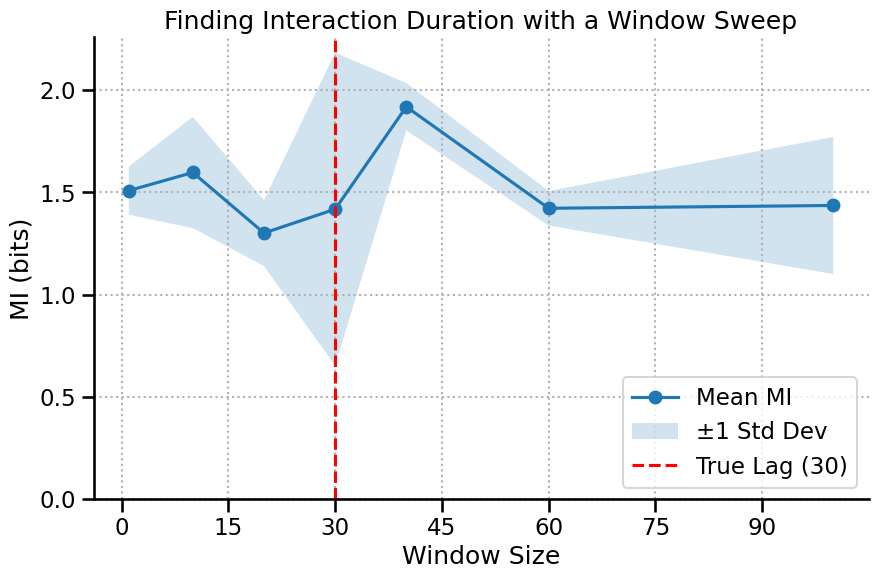

--- Best Result ---
Optimal Window Size: 40.0


In [11]:
ax = window_results.plot(show=False)
ax.axvline(x=ground_truth_lag, color='red', linestyle='--', label=f'True Lag ({ground_truth_lag})')
ax.set_title("Finding Interaction Duration with a Window Sweep")
ax.set_xlabel("Window Size")
ax.legend()
ax.set_ylim(bottom=0)
plt.show()

best_run = window_results.dataframe.loc[window_results.dataframe['mi_mean'].idxmax()]
print(f"--- Best Result ---\nOptimal Window Size: {best_run['window_size']}")

The result is a clean curve with a sharp peak at a `window_size` of 40. This makes intuitive sense: a window of 40 is the first one in our test that is comfortably larger than the 30-step lag, allowing the CNN to reliably see the full relationship.

## 3. Part 2: Finding the Precise Offset (`mode='lag'`)

The `window_size` sweep tells us the *duration* of the interaction, but what if we want to find the exact *offset*? For this, the library provides a dedicated `mode='lag'`.

This mode systematically shifts `y_data` relative to `x_data` by a range of values and computes the MI at each step. This is perfect for finding the precise delay at which the information between two signals is maximal.

In [13]:
# For lag analysis, we need to fix the window size.
# We'll use the optimal one we just found.
processor_params = {'window_size': 40}

# We'll test a range of lags from -50 to +50.
lag_range = range(-50, 51, 10)

lag_results = nmi.run(
    x_data=x_raw, 
    y_data=y_raw,
    mode='lag',
    processor_type_x='continuous',
    processor_params_x=processor_params,
    base_params=base_params, 
    lag_range=lag_range,
    n_workers=2,
    random_seed=42
)

2025-10-08 03:07:40 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-08 03:07:40 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-08 03:07:40 - neural_mi - INFO - Starting parameter sweep with 2 workers...


python(21948) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21949) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Parameter Sweep Progress:   0%|          | 0/11 [00:00<?, ?task/s]

Run 18c6efec-3835-4060-bab2-e36ec0f0ac41_c10 | MI: 2.777:  98%|█████████▊| 49/50 [00:24<00:00,  1.81it/s]

2025-10-08 03:10:16 - neural_mi - INFO - Parameter sweep finished.


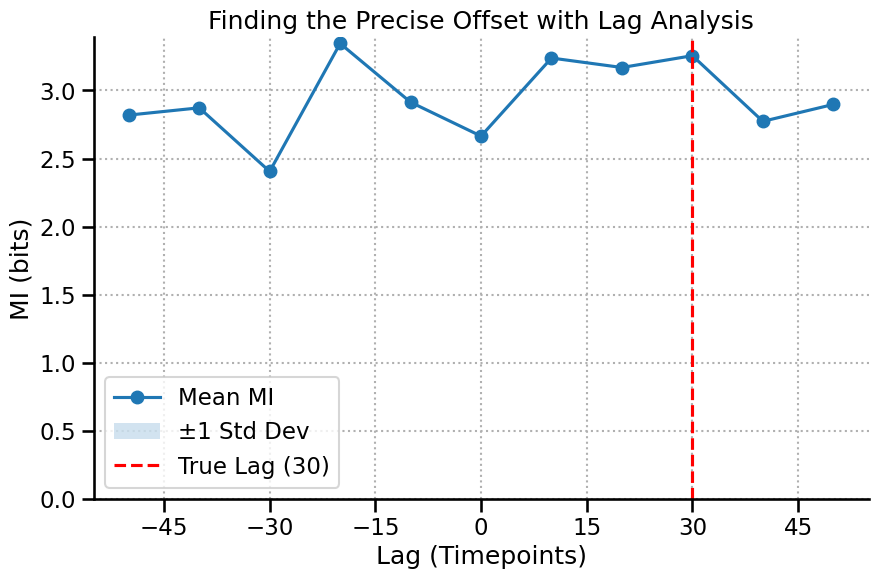

--- Best Result ---
Optimal Lag: -20.0


In [14]:
ax = lag_results.plot(show=False)
ax.axvline(x=ground_truth_lag, color='red', linestyle='--', label=f'True Lag ({ground_truth_lag})')
ax.set_title("Finding the Precise Offset with Lag Analysis")
ax.set_xlabel("Lag (Timepoints)")
ax.legend()
ax.set_ylim(bottom=0)
plt.show()

best_lag = lag_results.dataframe.loc[lag_results.dataframe['mi_mean'].idxmax()]
print(f"--- Best Result ---\nOptimal Lag: {best_lag['lag']}")

Perfect! The analysis produces a sharp peak right at a lag of 30, exactly matching our ground truth.

## 4. Conclusion

You now have a complete toolkit for analyzing temporal relationships in your data.

- To find the **duration** of an interaction, or the timescale on which it occurs, perform a **sweep on `window_size`**.

- To find the precise **temporal offset** or delay between two signals, use **`mode='lag'`**.

By combining these two techniques, you can build a comprehensive picture of the dynamic relationships in your neural data. In the next tutorial, we'll dive deeper into the model choices we made here, exploring the trade-offs between different critic architectures and MI estimators.